# e-SFR ISO12233: Slanted-Edge Analysis with Polynomial Edge Fitting

From a selected edge area of an image (ROI), the program computes ISO slanted edge SFR.

In [2]:
import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift

In [3]:
from common import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

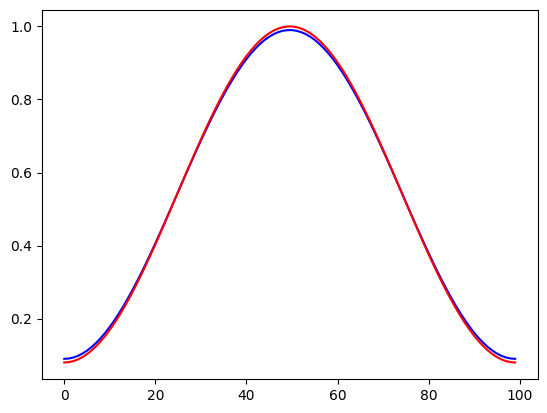

In [4]:
# plot a hamming window filter with window width=100
test_get_hamming = get_hamming(100)
plt.plot(test_get_hamming, 'b')
plt.plot(np.hamming(100), 'r')

In [5]:
def get_mtf(test, f):
    is_edge = True
    image_filename = None
    
    image_filename = "edge_computed_1deg_noise_mono.tif"
    if test == 'smartmtf':
      image_filename = "smartmtf/pos9.9_sharpest.tiff" # for smartmtf
    elif test == 'dome':
      image_filename = "DomeCamera/-7.85_sharpest.tiff" # for dome
    image_filename = f
    # image_filename = "cross_hair.png"
    # image_filename = "Red_Left_X0Y0_Cam 2_ROI1_increase.tiff"
    special_flag = 1
    # image_filename = "edge_computed_25deg_noise.tif"
    
    # image_filename = "edge_computed_5deg.tif"
    # image_filename = "edge_computed_25deg.tif"
    # image_filename = "edge_computed_44deg.tif"
    # image_filename = "edge_computed_89deg.tif"
    
    ##### Global config
    
    # (optional) sampling interval, 1 means cy/pixel
    del1 = 1
    sunit = "mm"
    funit = "cy/pixel"
    
    # order of polynomial fit to edge [1-5]
    npol = 1 # linear
    
    # smoothing window
    # 0: (default) Tukey smoothing window
    # 1: Hamming window
    wflag = 1
    
    # Tukey window parameter
    alpha = 1
    
    # r,g,b weights used to compute luminance record
    # default = [0.213, 0.715, 0.072]
    weight = [0.213, 0,715, 0.072]
    
    smax = 255
    
    nbin = 4
    
    lowhi = 0
    fil1 = [0.5, -0.5]
    fil2 = [0.5, -0.5]
    
    deg = 1
    
    ################################################################################
    # Step 0. load image
    ################################################################################
    
    raw_image = read_image(image_filename)
    rotation= 0
    # raw_image = rotate(raw_image, rotation)
    raw_image_w = raw_image.shape[0]
    raw_image_h = raw_image.shape[1]
    # print("raw_image width:", raw_image_w)
    # print("raw_image height:", raw_image_h)
    # print("raw_image shape:", raw_image.shape)
    # plt.title("raw image")
    # plt.imshow(raw_image, 'gray')
    # print(np.max(raw_image), np.min(raw_image))
    
    ## # Step 1. Get ROI
    ################################################################################
    
    # roi_image, roi = get_roi(raw_image, [80, 40], [180, 200])
    if rotation == 0:
        offset = -110
    elif rotation == -1:
        offset = -75
    elif rotation == -2:
        offset = -35
    elif rotation == -3:
        offset = 4
    elif rotation == -4:
        offset = 40
    elif rotation == -5:
        offset = 80
        
    # print(raw_image.shape[0], raw_image.shape[1])
    # print(is_edge)
    # print(offset)
    # print(raw_image.shape)
    
    if is_edge:
      roi_image, roi = get_roi(raw_image, [2600+offset, 600], [2610+111+offset, 1000]) # for edge
      if test == 'smartmtf':
        roi_image, roi = get_roi(raw_image, [1310, 1150], [1430, 1270]) # for smart mtf
      elif test == 'dome':
        roi_image, roi = get_roi(raw_image, [1050, 1090], [1140, 1180]) # for dome
    else:
      roi_image, roi = get_roi(raw_image, [2450-600, 600], [2850+800, 1000]) # for cross-hair
    #   roi_image, roi = get_roi(raw_image, [1600, 300], [raw_image.shape[1] - 1700, raw_image.shape[0]-700]) # for cross-hair
    
    # print(roi_image.shape, roi)
    special_flag = 0
    if special_flag == 1:
        roi_image = raw_image
        roi.ul.x = 0
        roi.ul.y = 0
        roi.lr.x = roi_image.shape[0]
        roi.lr.y = roi_image.shape[1]
    special_flag = 1
    
    # plt.title("roi image")
    # plt.imshow(roi_image, "gray")
    # print("upper left:", roi.ul.x, roi.ul.y)
    # print("lower right:", roi.lr.x, roi.lr.y)
    roi_image = roi_image.astype(np.float32)
    
    # TODO: clip
    
    # TODO: rotate if required
    
    # Check for "positive" edge
    tleft = np.sum(roi_image[:, :5])
    tright = np.sum(roi_image[:, -5:])
    if tleft > tright:
        lowhi = 1
        fil1 = [-0.5, 0.5]
        fil2 = [-0.5, 0, 0.5]
    else:
        lowhi = 0
        fil1 = [0.5, -0.5]
        fil2 = [0.5, 0, -0.5]
        
    # print(tleft, tright)
    # Check for low contrast edge
    contrast = abs((tleft-tright)/(tleft+tright))
    # print(contrast)
    if contrast < 0.2:
        print("WARNING: Edge contrast is less than 20%, this can lead to high error in the SFR measurement.")
        
    cv2.imwrite("edge.png", roi_image)
    
    ################################################################################
    # Step 2. Prepare for Edge location Estimation
    ################################################################################
    
    win1 = get_hamming(roi_image.shape[1])
    # plt.title("hamming window")
    # plt.plot(win1)
    
    ################################################################################
    # Step 3. Get Derivative
    ################################################################################
    # print(is_edge)
    # print('roi_image.shape', roi_image.shape)
    if is_edge:
      deriv = np.apply_along_axis(lambda a: get_deriv1(a, fil1), axis = 1, arr=roi_image)
    else:
      deriv = roi_image
    # print('deriv.shape', deriv.shape)
    # deriv = get_deriv1(roi_image[0, :], fil1)
    # plt.subplot(1, 2, 1)
    # plt.title("LSF")
    # for i in range(deriv.shape[0]):
    #     plt.plot(deriv[i, :])
    
    # plt.subplot(1, 2, 2)
    # plt.plot(deriv[0, :])
    
    ################################################################################
    # Step 4. Apply window and compute centroid
    ################################################################################
    
    # -0.5 shift for FIR phase
    if wflag == 1:
        centroid = get_centroid(deriv * win1) - 0.5
    else:
        centroid = get_centroid(deriv) - 0.5
        
    # print(centroid)
    
    # plt.title("LSF and fitting")
    # print(deriv.min())
    # plt.imshow(deriv)
    
    # plt.plot(centroid, np.arange(len(centroid)), 'r')
    
    # Polyfit
    x = np.arange(len(centroid))
    y = centroid
    
    fit = get_polyfit(x, y, deg)
    
    # plt.plot(np.polyval(fit, x), x, "y")
    
    # print("Polyfit coefficients:", fit)
    
    ################################################################################
    # Step 5. Compute polynomial fit to central locations
    ################################################################################
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    # print(centroid_place)
    hamming_width = deriv.shape[1]
    
    
    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    wflag=0
    # print("wflag:", wflag)
    # print("deriv:", deriv)
    # print("win2:", win2)
    if wflag == 1:
        deriv_hamming_windowed = deriv * win2
    else:
        deriv_hamming_windowed = deriv
        
    # plt.imshow(deriv_hamming_windowed)
    
    centroid = get_centroid(deriv_hamming_windowed)
    # print(centroid)
    # plt.plot(centroid, np.arange(len(centroid)), 'r')
    
    x = np.arange(len(centroid))
    y = centroid
    # print(x)
    # print(y)
    fit = get_polyfit(x, y, deg)
    # print("fit:", fit)
    # plt.plot(np.polyval(fit, x), x, "y")
    
    
    slout = -fit[0]
    # print("slope:", slout)
    slout = 180*math.atan(slout)/math.pi
    # print("slope angle of fitme (deg):", slout)
    
    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv.shape[0]/2)
    
    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlinl = round(a/b)
    # print("limit of line number:", nlinl)
    
    # Limit the number of lines to integer(npix*line slope) as per ISO 12233
    roi_image = roi_image[:nlinl, :]
    # print("roi_image shape limited to:", roi_image.shape)
    # plt.imshow(roi_image)
    
    vslope = -fit[0]
    slope_deg = slout
    
    delimage = del1
    
    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))
    # print("delfac:", delfac)
    
    # input pixel sampling normal to edge
    del1n = del1*delfac
    # print("del1n:", del1n)
    
    # super-sampling interval normal to edge
    del2 = del1n/nbin
    # print("del2", del2)
    
    nn = math.ceil(deriv.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1
    # print("nn, nn2:", nn, nn2)
    
    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)
    
    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)
    
    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)
    
    ################################################################################
    # Step 6. Form super-sampled edge profile by shifting and binning (ESF)
    ################################################################################
    
    # print(roi_image.shape)
    # print(fit)
    esf = project2(roi_image, fit, nbin)
    l = len(esf)
    # print(l)
    esf[l-1]=esf[l-2]
    # esf = savgol_filter(esf, 31, 3)
    # plt.plot(esf)
    
    ################################################################################
    # Step 7. Compute 1-D derivative of super-sampled edge data (LSF)
    ################################################################################
    
    # if not is_edge:
    #     esf = np.cumsum(esf)
    
    lsf1 = get_deriv1(esf, fil2)
    if not is_edge:
        lsf1 = esf
    # print(len(lsf1))
    # lsf1 = [l + 2 for l in lsf1]
    # plt.plot(lsf1)
    
    # print(lsf1)
    
    ################################################################################
    # Step 8. Apply window to edge-derivative (LSF)
    ################################################################################
    
    nn = len(lsf1)
    mm = np.argmax(lsf1)
    
    win3 = get_hamming(nn, mm)
    win3 = np.array(win3)
    lsf1 = np.array(lsf1)
    if wflag == 1:
        lsf = lsf1 * win3
    else:
        lsf = lsf1
        
    # plt.subplot(1, 2, 1)
    # plt.title("without hamming")
    # plt.plot(lsf)
    
    # plt.subplot(1, 2, 2)
    # plt.title("hamming")
    # plt.plot(lsf1 * win3)
    # plt.plot(win3*200)
    
    # lsf
    # print(_lsf)
    
    ################################################################################
    # Step 9. Compute normalized modulus of the DFT of thw windowed LSF
    #         Transform, scale and correct for FIR filter response
    ################################################################################
    
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values
    # print("del2", del2, "nn", nn)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)
    
    if test == 'smartmtf':
        nn2out=90 # for smartmtf
        efl = 60
        px = 3.45
    elif test == 'dome':
        nn2out=60 # for dome
        efl = 94.45
        px = 5.5
    
    lppd = px/efl/1000 * 180/3.14159
    
    # print("number of data points:", nn2out)
    
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # fig.suptitle(f'{test} FFT and MTF')
    # ax1.plot(temp)
    # ax2.plot(freq[0:nn2out]/lppd, mtf[0:nn2out])
    # print(freq[0:nn2out]/lppd)

    return freq[0:nn2out]/lppd, mtf[0:nn2out], dcorr, nn2out, freq


C:\repos\OICP\notebooks\common.py:139: RuntimeWarning: invalid value encountered in scalar divide
  esf = [barray[1, i + start]/barray[0, i + start] for i in range(nn)]


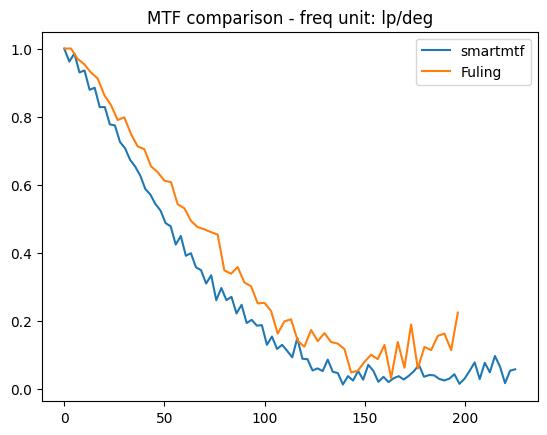

In [6]:

# image file names

def get_image_by_test(test):
    if test == 'smartmtf':
      image_filename = "smartmtf/pos9.9_sharpest.tiff" # for smartmtf
      # image_filename = "smartmtf/pos10.0.tiff" # for smartmtf
    elif test == 'dome':
      image_filename = "DomeCamera/-7.85_sharpest.tiff" # for dome
      # image_filename = "DomeCamera/-7.90.tiff" # for dome

    return image_filename
    
test = 'smartmtf'
f1, m1, dcorr1, nn2out1, freq1 = get_mtf(test, get_image_by_test(test))

test = 'dome'
f2, m2, dcorr2, nn2out2, freq2 = get_mtf(test, get_image_by_test(test))

plt.title('MTF comparison - freq unit: lp/deg')
plt.plot(f1, m1, label='smartmtf')
plt.plot(f2, m2, label='Fuling')
plt.legend()

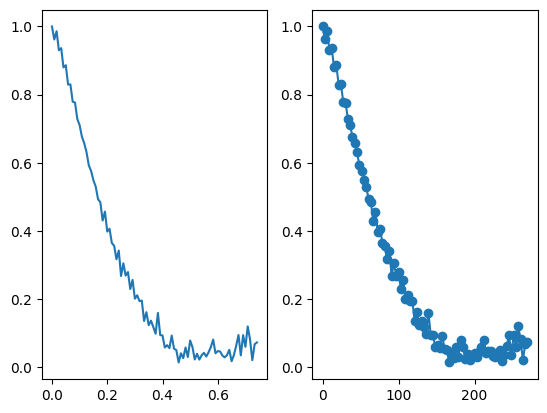

In [7]:
################################################################################
# Step 10. Correct e-SFR data for discrete derivative response
################################################################################

# corrected MTF
# print(dcorr1.shape)
# print(m1.shape)
dcorr = dcorr1[0:m1.shape[0]]
mtf_c = m1 * dcorr
# print(len(mtf_c))
# print(nn2out1)
# print(dcorr)
# plt.plot(freq1[0:nn2out1], mtf_c[0:nn2out1])
plt.subplot(1, 2, 1)
plt.plot(freq1[0:nn2out1], mtf_c[0:nn2out1])
# print(freq1[0:15])
# print(mtf_c[0:15])

plt.subplot(1, 2, 2)
pixel_size = 0.00275
plt.plot(np.array(freq1[0:nn2out1])/pixel_size, mtf_c[0:nn2out1], '-o')
